In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

C:\Users\APC\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
props_2016 = pd.read_csv("./../data/properties_2016.csv")
train_2016 = pd.read_csv("./../data/train_2016_v2.csv")
sample = pd.read_csv("./../data/sample_submission.csv")

sample['parcelid'] = sample['ParcelId']
sample = sample.drop(['ParcelId'],axis=1)

<ipython-input-2-f3d09a79a100>:1: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  props_2016 = pd.read_csv("./../data/properties_2016.csv")


# REDUCE MEMORY USAGE

In [3]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
#             # Print current column type
#             print("******************************")
#             print("Column: ",col)
#             print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype('int64')
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                    props[col] = props[col].astype('Int8')
                elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                    props[col] = props[col].astype('Int16')
                elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                    props[col] = props[col].astype('Int32')
                elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                    props[col] = props[col].astype('Int64')    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype('float32')
            
#             # Print new column type
#             print("dtype after: ",props[col].dtype)
#             print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props

In [4]:
props_2016 = reduce_mem_usage(props_2016)

Memory usage of properties dataframe is : 1320.9732208251953  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  614.9358749389648  MB
This is  46.55172907705291 % of the initial size


# DEAL WITH MISSING DATA AND REMOVE REDUNDANT FEATURES

In [5]:
df_train_2016 = train_2016.merge(props_2016, how='left', on='parcelid')
df_train_2016 = df_train_2016.drop(['parcelid', 'transactiondate'], axis=1)

df_predict_2016 = sample.merge(props_2016, how='left', on='parcelid')
df_predict_2016 = df_predict_2016.drop(['201610','201611','201612','201710','201711','201712'], axis=1)

<ipython-input-100-11a8e084d6ca>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=df_predict_2016[numcols].corr())


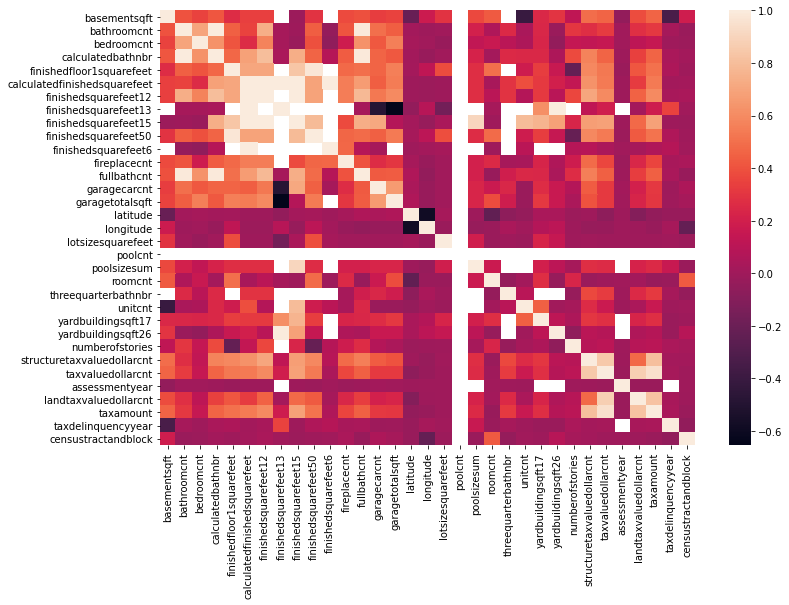

<Figure size 432x288 with 0 Axes>

In [100]:
#Identify numerical columns to produce a heatmap
#remove id, bool, year
catcols = ['airconditioningtypeid','architecturalstyletypeid','buildingqualitytypeid','buildingclasstypeid','decktypeid','fips','hashottuborspa','heatingorsystemtypeid','pooltypeid10','pooltypeid2','pooltypeid7','propertycountylandusecode','propertylandusetypeid','propertyzoningdesc','rawcensustractandblock','regionidcity','regionidcounty','regionidneighborhood','regionidzip','storytypeid','typeconstructiontypeid','yearbuilt','taxdelinquencyflag']
numcols = [x for x in df_predict_2016.columns if x not in catcols]

#Lets start by plotting a heatmap to determine if any variables are correlated
plt.figure(figsize = (12,8))
sns.heatmap(data=df_predict_2016[numcols].corr())
plt.show()
plt.gcf().clear()

In [101]:
missingvalues_prop = (df_predict_2016.isnull().sum()/len(df_predict_2016)).reset_index()
missingvalues_prop.columns = ['field','proportion']
missingvalues_prop = missingvalues_prop.sort_values(by = 'proportion', ascending = False)
missingvalues_prop

,field,proportion
40,storytypeid,0.999456
2,basementsqft,0.999455
45,yardbuildingsqft26,0.999113
48,fireplaceflag,0.998270
1,architecturalstyletypeid,0.997970
42,typeconstructiontypeid,0.997740
12,finishedsquarefeet13,0.997430
5,buildingclasstypeid,0.995769
8,decktypeid,0.994273
15,finishedsquarefeet6,0.992630


In [6]:
def preprocess(df):
    dropcols = []

    # too many missing values and same info with 'calculatedfinishedsquarefeet'  
    dropcols =  dropcols + ['finishedsquarefeet13','finishedsquarefeet15','finishedfloor1squarefeet','finishedsquarefeet50','finishedsquarefeet6','finishedsquarefeet12','basementsqft','yardbuildingsqft26']

    #too many missing values and same info with  pooltypid2
    dropcols = dropcols + ['pooltypeid10', 'pooltypeid7', 'hashottuborspa']

    # 99% missing values and cannot impute data because this is ID
    dropcols = dropcols + ['storytypeid', 'buildingclasstypeid', 'architecturalstyletypeid','typeconstructiontypeid']


    #same information with fireplacecnt
    dropcols.append('fireplaceflag')

    #same information with bathroomcnt 
    dropcols = dropcols + ['threequarterbathnbr', 'calculatedbathnbr', 'fullbathcnt']


    # same information with the sum of structuretaxvaluedollarcnt and landtaxvaluedollarcnt
    dropcols = dropcols + ['taxvaluedollarcnt', 'taxamount']

    # propertylandusetypeid already provides similar information
    dropcols = dropcols + ['propertyzoningdesc', 'propertycountylandusecode']

    # regionidcounty, latitude, longitude already provides similar information, are better region based features 
    # over 60% of the dataset missing values and 500+ unique value
    dropcols = dropcols + ['regionidneighborhood', 'regionidzip', 'regionidcity']

    #taxdelinquencyflag provides same information
    #over 97%
    dropcols.append('taxdelinquencyyear')

    #Duplicate information from bedroomcnt and roomcnt shows inconsistent data with majority of properties having 0 rooms in the principal residence
    dropcols.append('roomcnt')

    #With over 77% of the missing values and no one value dominating the variable distribution, it is impractical to impute and introduce incorrect information.
    dropcols.append('numberofstories')

    #Dropping as the variable has only one unique value in the dataset.
    dropcols.append('assessmentyear')

    #With almost 58k unique values, these features are being dropped until further research can be done into incorporating information from them in the model algorithm.
    dropcols.append('rawcensustractandblock')
    dropcols.append('censustractandblock')
    
    ### 0 IMPUTATION

    #Data description says 'Patio in yard'. Missing values are likely zero for having no patio in yard
    index = df.yardbuildingsqft17.isnull()
    df.loc[index,'yardbuildingsqft17'] = 0

    #Missing values must indicate no fireplace present in the unit, thus imputing 0 for all missing values.
    index = df.fireplacecnt.isnull()
    df.loc[index,'fireplacecnt'] = 0

    #All values are 1 in data indicating one pool is present, missing values must be 0 indicating otherwise.
    index = df.poolcnt.isnull()
    df.loc[index,'poolcnt'] = 0

    #All missing values indicate no pool on property, thus impute 0 for sqaure footage of all pools.
    index = df.poolsizesum.isnull()
    df.loc[index,'poolsizesum'] = 0

    #All values are 1 in data indicating a pool with spa/hot tub is present, missing values must be 0 indicating otherwise.
    index = df.pooltypeid2.isnull()
    df.loc[index,'pooltypeid2'] = 0

    #Same value in data indicating a deck is present, missing values must be 0 indicating no deck.
    index = df.decktypeid.isnull()
    df.loc[index,'decktypeid'] = 0

    #Assume if Null in garage count it means there are no garages
    index = df.garagecarcnt.isnull()
    df.loc[index,'garagecarcnt'] = 0

    #Likewise no garage means the size is 0 by default
    index = df.garagetotalsqft.isnull()
    df.loc[index,'garagetotalsqft'] = 0

    #All values are Y in data for properties that are tax delinquent implying all missing values must be N or 0 for easier handling
    index = df.taxdelinquencyflag.isnull()
    df.loc[index,'taxdelinquencyflag'] = 'N'
    df.loc[df['taxdelinquencyflag'] == 'Y','taxdelinquencyflag'] = 1
    df.loc[df['taxdelinquencyflag'] == 'N','taxdelinquencyflag'] = 0
    df['taxdelinquencyflag'] = df['taxdelinquencyflag'].astype('int32')


    ### Mode Imputation Features
    # The following features are imputed with the most frequent value (mode) due to the majority of the dataset having that specific value.

    # airconditioningtypeid: Majority of the properties have a Central air conditioning type.
    df['airconditioningtypeid'] = df['airconditioningtypeid'].fillna(df['airconditioningtypeid'].mode()[0])

    # heatingorsystemtypeid: Majority of the properties have a Central heating system.
    df['heatingorsystemtypeid'] = df['heatingorsystemtypeid'].fillna(df['heatingorsystemtypeid'].mode()[0])

    # unitcnt: Majority of the property are built into 1 unit.
    df['unitcnt'] = df['unitcnt'].fillna(df['unitcnt'].mode()[0])

    # yearbuilt: Since missing rows is extremely low, mode suffices
    df['yearbuilt'] = df['yearbuilt'].fillna(df['yearbuilt'].mode()[0])
    
    #fips, propertylandusetypeid, regionidcounty: With only 0.4% of the dataset missing values, imputing the mode is acceptable.
    df['fips'] = df['fips'].fillna(df['fips'].mode()[0])
    df['propertylandusetypeid'] = df['propertylandusetypeid'].fillna(df['propertylandusetypeid'].mode()[0])
    df['regionidcounty'] = df['regionidcounty'].fillna(df['regionidcounty'].mode()[0])


    ### Median Imputation Features
    #The following features are imputing with the 50th percentile value (median) to best represent the numerical distributions represented by each features.

    # buildingqualitytypeid: Overall condition of the condition from best (lowest) to worst (highest). Thus, imputing the median for missing values.
    df['buildingqualitytypeid'] = df['buildingqualitytypeid'].fillna(df['buildingqualitytypeid'].median())

    # lotsizesquarefeet: Continuous numerical variable for area of the lot
    df['lotsizesquarefeet'] = df['lotsizesquarefeet'].fillna(df['lotsizesquarefeet'].median())

    # calculatedfinishedsquarefeet
    df['calculatedfinishedsquarefeet'] = df['calculatedfinishedsquarefeet'].fillna(df['calculatedfinishedsquarefeet'].median())

    # structuretaxvaluedollarcnt
    df['structuretaxvaluedollarcnt'] = df['structuretaxvaluedollarcnt'].fillna(df['structuretaxvaluedollarcnt'].median())

    #landtaxvaluedollarcnt
    df['landtaxvaluedollarcnt'] = df['landtaxvaluedollarcnt'].fillna(df['landtaxvaluedollarcnt'].median())
    
    #bathroomcnt
    df['bathroomcnt'] = df['bathroomcnt'].fillna(df['bathroomcnt'].median())
    
    #bedroomcnt
    df['bedroomcnt'] = df['bedroomcnt'].fillna(df['bedroomcnt'].median())
    
    #latitude
    df['latitude'] = df['latitude'].fillna(df['latitude'].median())
    
    #longitude
    df['longitude'] = df['longitude'].fillna(int(df['longitude'].median()))
    
    df = df.drop(dropcols,axis=1)
    return df

In [7]:
df_train_16 = preprocess(df_train_2016)
df_train_16.to_csv('./../preprocessed data/df_train_2016.csv',index=False)

In [8]:
df_predict_16 = preprocess(df_predict_2016)
df_predict_16.to_csv('./../preprocessed data/df_predict_2016.csv',index=False)